<a href="https://colab.research.google.com/github/jjungmini/solar1/blob/main/%EC%95%88%EC%A0%95%EB%AF%BC_230912.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 MB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.42.0.3-py2.py3-none-any.whl size=240945068 sha256=6be3773cb8887726e8046faeb864feeb70434c239abf62bf0bf4166170d8adbb
  Stored in directory: /root/.cache/pip/wheels/f9/7d/1d/e1258f0558603969a8393cb5b22a18e313337f01627a118302
Successfully built h2o


In [62]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import h2o
from h2o.automl import H2OAutoML
import seaborn as sns
from prophet import Prophet

In [63]:
import itertools
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

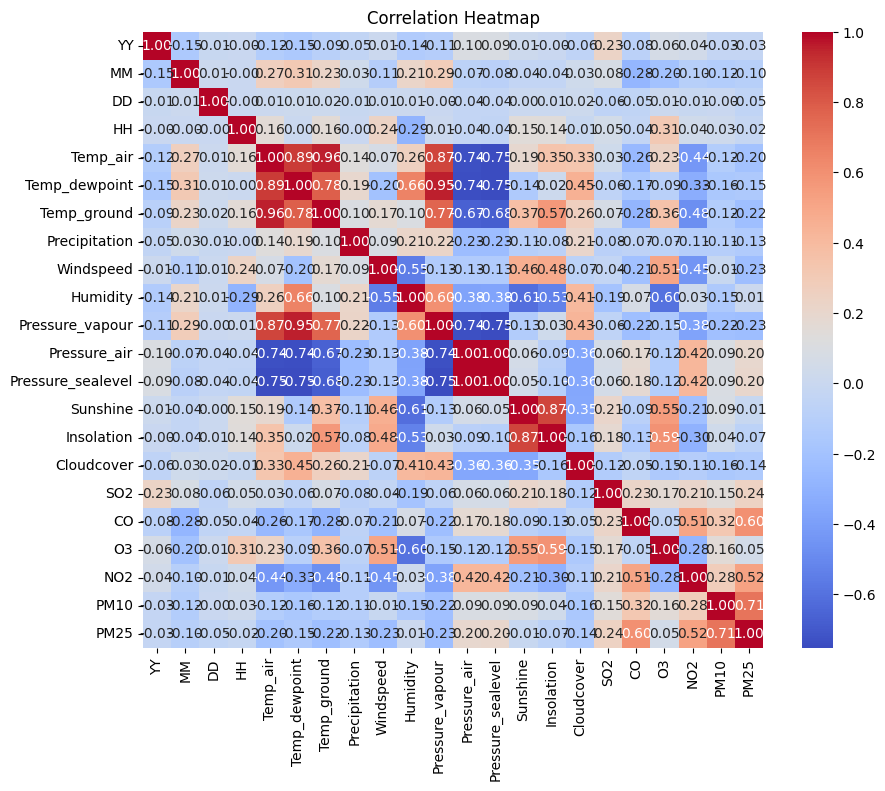

In [64]:
# 데이터 로딩
df = pd.read_csv('solar_with_emissions_0228.csv')

# 날짜를 datetime 타입으로 변환
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d-%H')

# 타겟 변수를 위한 별도의 스케일러 정의
target_scaler = MinMaxScaler()
df['Solarpower'] = target_scaler.fit_transform(df[['Solarpower']])

# 특성만 정규화하기 위해 Scaler 정의
scaler = MinMaxScaler()

# 특성들 간의 상관관계 계산을 위해 타겟 변수 제외
correlation_matrix = df.drop(columns=['Date', 'Solarpower']).corr()

# 상관관계 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [65]:
# Solarpower 제외하고 정규화
features = df.drop(columns=['Date', 'Solarpower'])
scaled_features = scaler.fit_transform(features)
df[features.columns] = scaled_features

# 훈련 데이터와 테스트 데이터로 분리
train = df[df['Date'] < '2022-12-01']
test = df[(df['Date'] >= '2022-12-01') & (df['Date'] < '2023-01-01')]

In [43]:
test

,Date,YY,MM,DD,HH,Solarpower,Temp_air,Temp_dewpoint,Temp_ground,Precipitation,...,Pressure_sealevel,Sunshine,Insolation,Cloudcover,SO2,CO,O3,NO2,PM10,PM25
25560,2022-12-01 00:00:00,0.666667,1.0,0.0,0.000000,0.002385,0.241926,0.201322,0.161320,0.0,...,0.910823,0.0,0.0,0.935714,0.255555,0.222222,0.275758,0.124510,0.011885,0.049689
25561,2022-12-01 01:00:00,0.666667,1.0,0.0,0.043478,0.000186,0.238256,0.209722,0.161776,0.0,...,0.910720,0.0,0.0,1.000000,0.277778,0.222222,0.284848,0.096078,0.011205,0.033126
25562,2022-12-01 02:00:00,0.666667,1.0,0.0,0.086957,0.001703,0.235320,0.220050,0.159379,0.0,...,0.911647,0.0,0.0,0.964286,0.272222,0.222222,0.287879,0.099020,0.010866,0.039337
25563,2022-12-01 03:00:00,0.666667,1.0,0.0,0.130435,0.001827,0.234733,0.231479,0.160064,0.0,...,0.912161,0.0,0.0,0.957143,0.277778,0.222222,0.293939,0.075490,0.010866,0.055901
25564,2022-12-01 04:00:00,0.666667,1.0,0.0,0.173913,0.000898,0.234880,0.241669,0.159151,0.0,...,0.903717,0.0,0.0,0.957143,0.283333,0.222222,0.300000,0.070588,0.011885,0.043478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2022-12-31 19:00:00,0.666667,1.0,1.0,0.826087,0.101992,0.314739,0.364638,0.154241,0.0,...,0.881372,0.0,0.0,0.000000,0.238889,0.370370,0.290909,0.205882,0.031919,0.132505
26300,2022-12-31 20:00:00,0.666667,1.0,1.0,0.869565,0.081798,0.291544,0.362159,0.146364,0.0,...,0.885388,0.0,0.0,0.000000,0.250000,0.333333,0.315152,0.220588,0.034975,0.151139
26301,2022-12-31 21:00:00,0.666667,1.0,1.0,0.913043,0.056834,0.276864,0.363261,0.139856,0.0,...,0.887653,0.0,0.0,0.007143,0.244445,0.370370,0.293939,0.201471,0.039389,0.167702
26302,2022-12-31 22:00:00,0.666667,1.0,1.0,0.956522,0.031127,0.255432,0.361195,0.133349,0.0,...,0.884873,0.0,0.0,0.107143,0.238889,0.407407,0.236364,0.200000,0.041087,0.202899


# FEATURE SELECTION

In [66]:
# 훈련 데이터를 이용하여 특성 선택을 위한 ElasticNetCV 모델을 생성합니다
enet_train = ElasticNetCV(
    alphas=[0.001, 0.01, 0.1, 1, 10],        # 후보 alpha 값 리스트
    l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],     # 후보 l1_ratio 값 리스트
    cv=5,                                   # 5-fold cross-validation 사용
    n_alphas=1000,                           # 100개의 alpha 값 생성
    max_iter=1000,                          # 최대 반복 횟수
    tol=1e-4,                               # 수렴 기준
    verbose=False,                          # 로그 출력 비활성화
    precompute='auto',                      # 자동으로 사전 계산된 Gram 행렬 결정
    selection='random',                      # 랜덤하게 특성 선택
    random_state=42
)
enet_train.fit(train.drop(columns=['Date', 'Solarpower']), train['Solarpower'])
# alpha 값을 출력합니다.
print('Best alpha: ', enet_train.alpha_)

# 선택된 특성만 남김
selected_features_train = train.drop(columns=['Date', 'Solarpower']).columns[enet_train.coef_ != 0]
train = train[['Date', 'Solarpower'] + selected_features_train.tolist()]

# 선택된 특성 출력
print("Selected features: ", selected_features_train.tolist())

Best alpha:  0.001
Selected features:  ['YY', 'MM', 'DD', 'HH', 'Temp_air', 'Temp_ground', 'Windspeed', 'Humidity', 'Pressure_air', 'Pressure_sealevel', 'Sunshine', 'Insolation', 'Cloudcover', 'CO', 'O3', 'NO2']


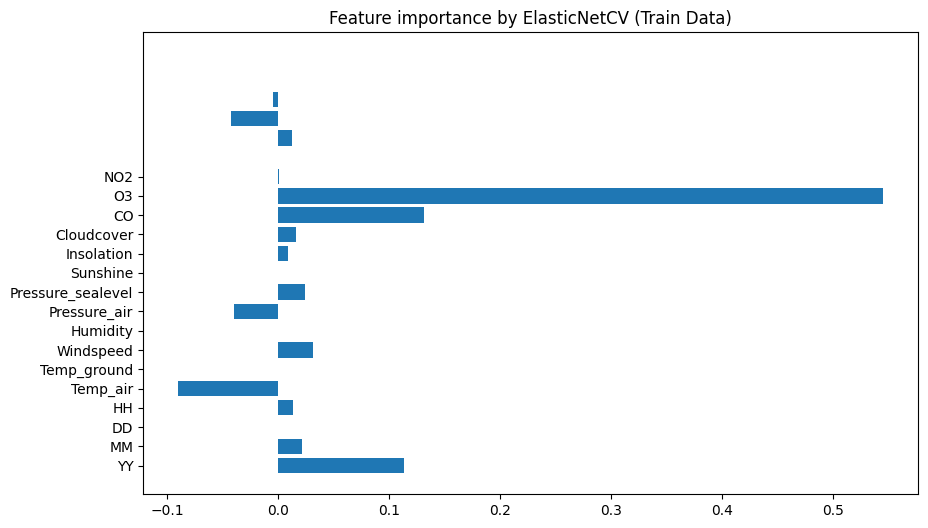

In [67]:
# ElasticNetCV의 결과를 출력합니다.
# 특성 중요도를 시각화합니다.
plt.figure(figsize=(10, 6))
plt.barh(range(len(enet_train.coef_)), enet_train.coef_)
plt.yticks(range(len(selected_features_train)), train.drop(columns=['Date', 'Solarpower']).columns)
plt.title('Feature importance by ElasticNetCV (Train Data)')
plt.show()

In [47]:
train

,Date,Solarpower,YY,MM,DD,HH,Temp_air,Temp_ground,Windspeed,Humidity,Pressure_air,Pressure_sealevel,Sunshine,Insolation,Cloudcover,CO,O3,NO2
0,2020-01-01 00:00:00,0.003779,0.000000,0.000000,0.000000,0.000000,0.180417,0.079233,0.234509,0.335749,0.917782,0.923283,0.0,0.0,0.014286,0.333333,0.260606,0.132353
1,2020-01-01 01:00:00,0.001239,0.000000,0.000000,0.000000,0.043478,0.176453,0.075009,0.246902,0.320451,0.918305,0.923592,0.0,0.0,0.007143,0.333333,0.245455,0.120588
2,2020-01-01 02:00:00,0.000805,0.000000,0.000000,0.000000,0.086957,0.167499,0.070670,0.239276,0.338969,0.921234,0.926887,0.0,0.0,0.000000,0.333333,0.254545,0.114706
3,2020-01-01 03:00:00,0.000000,0.000000,0.000000,0.000000,0.130435,0.160893,0.067473,0.195424,0.367150,0.917469,0.923283,0.0,0.0,0.014286,0.333333,0.248485,0.113235
4,2020-01-01 04:00:00,0.001208,0.000000,0.000000,0.000000,0.173913,0.162654,0.069528,0.224023,0.429952,0.914435,0.920297,0.0,0.0,0.021429,0.333333,0.254545,0.108824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25555,2022-11-30 19:00:00,0.086443,0.666667,0.909091,0.966667,0.826087,0.281415,0.186323,0.297426,0.275362,0.893724,0.894450,0.0,0.0,0.871429,0.259259,0.290909,0.135294
25556,2022-11-30 20:00:00,0.052312,0.666667,0.909091,0.966667,0.869565,0.273341,0.180843,0.326025,0.265700,0.898431,0.899186,0.0,0.0,0.964286,0.222222,0.296970,0.126471
25557,2022-11-30 21:00:00,0.022765,0.666667,0.909091,0.966667,0.913043,0.266001,0.176504,0.346044,0.252818,0.902615,0.903409,0.0,0.0,0.964286,0.222222,0.306061,0.101961
25558,2022-11-30 22:00:00,0.008146,0.666667,0.909091,0.966667,0.956522,0.257780,0.170567,0.348904,0.260870,0.906904,0.907939,0.0,0.0,0.921429,0.222222,0.293939,0.108824


# prophet

In [68]:
#prophet 학습 데이터 생성
prophet_train = train.rename(columns={'Date':'ds', 'Solarpower':'y'})
prophet_train = prophet_train[['ds', 'y'] + selected_features_train.tolist()]
prophet_train

,ds,y,YY,MM,DD,HH,Temp_air,Temp_ground,Windspeed,Humidity,Pressure_air,Pressure_sealevel,Sunshine,Insolation,Cloudcover,CO,O3,NO2
0,2020-01-01 00:00:00,0.003779,0.000000,0.000000,0.000000,0.000000,0.180417,0.079233,0.234509,0.335749,0.917782,0.923283,0.0,0.0,0.014286,0.333333,0.260606,0.132353
1,2020-01-01 01:00:00,0.001239,0.000000,0.000000,0.000000,0.043478,0.176453,0.075009,0.246902,0.320451,0.918305,0.923592,0.0,0.0,0.007143,0.333333,0.245455,0.120588
2,2020-01-01 02:00:00,0.000805,0.000000,0.000000,0.000000,0.086957,0.167499,0.070670,0.239276,0.338969,0.921234,0.926887,0.0,0.0,0.000000,0.333333,0.254545,0.114706
3,2020-01-01 03:00:00,0.000000,0.000000,0.000000,0.000000,0.130435,0.160893,0.067473,0.195424,0.367150,0.917469,0.923283,0.0,0.0,0.014286,0.333333,0.248485,0.113235
4,2020-01-01 04:00:00,0.001208,0.000000,0.000000,0.000000,0.173913,0.162654,0.069528,0.224023,0.429952,0.914435,0.920297,0.0,0.0,0.021429,0.333333,0.254545,0.108824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25555,2022-11-30 19:00:00,0.086443,0.666667,0.909091,0.966667,0.826087,0.281415,0.186323,0.297426,0.275362,0.893724,0.894450,0.0,0.0,0.871429,0.259259,0.290909,0.135294
25556,2022-11-30 20:00:00,0.052312,0.666667,0.909091,0.966667,0.869565,0.273341,0.180843,0.326025,0.265700,0.898431,0.899186,0.0,0.0,0.964286,0.222222,0.296970,0.126471
25557,2022-11-30 21:00:00,0.022765,0.666667,0.909091,0.966667,0.913043,0.266001,0.176504,0.346044,0.252818,0.902615,0.903409,0.0,0.0,0.964286,0.222222,0.306061,0.101961
25558,2022-11-30 22:00:00,0.008146,0.666667,0.909091,0.966667,0.956522,0.257780,0.170567,0.348904,0.260870,0.906904,0.907939,0.0,0.0,0.921429,0.222222,0.293939,0.108824


In [75]:
#모델 생성 및 학습
m = Prophet()
m.fit(prophet_train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpo1fbqr2_/y2o41fnx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo1fbqr2_/viwfi2wy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74383', 'data', 'file=/tmp/tmpo1fbqr2_/y2o41fnx.json', 'init=/tmp/tmpo1fbqr2_/viwfi2wy.json', 'output', 'file=/tmp/tmpo1fbqr2_/prophet_modelod9_so4u/prophet_model-20230911144326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:43:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:43:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [71]:
#하이퍼파라미터 튜닝
# changepoint_prior_scale, seasonality_prior_scale, holidays_prior_scale, seasonality_mode
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# 교차검증
for params in all_params:
    m = Prophet(**params).fit(prophet_train)  # Fit model with given params
    df_cv = cross_validation(m, initial='720 days', period='180 days', horizon = '180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpo1fbqr2_/upbbkgkr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo1fbqr2_/i8p_dw1c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17028', 'data', 'file=/tmp/tmpo1fbqr2_/upbbkgkr.json', 'init=/tmp/tmpo1fbqr2_/i8p_dw1c.json', 'output', 'file=/tmp/tmpo1fbqr2_/prophet_model4fnjacjc/prophet_model-20230911143537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:35:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:35:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2022-06-03 23:00:00 and 2022-06-03 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e44b5424250>
DEBUG:cmdstanpy:input tempfile: 

   changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.01                      0.1  0.143578
1                     0.01                      1.0  0.142344
2                     0.01                     10.0  0.142820
3                     0.10                      0.1  0.154945
4                     0.10                      1.0  0.155136
5                     0.10                     10.0  0.154610
6                     0.50                      0.1  0.211946
7                     0.50                      1.0  0.214364
8                     0.50                     10.0  0.216303


In [86]:
#최적 파라미터 출력
best_params = all_params[np.argmin(rmses)]
best_params

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}

In [88]:
#최적 모델 생성 및 학습
best_m = Prophet(changepoint_prior_scale = 0.01,
                 seasonality_prior_scale = 1.0)
best_m.fit(prophet_train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpo1fbqr2_/hxi9c_7v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo1fbqr2_/t4ee_4la.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63740', 'data', 'file=/tmp/tmpo1fbqr2_/hxi9c_7v.json', 'init=/tmp/tmpo1fbqr2_/t4ee_4la.json', 'output', 'file=/tmp/tmpo1fbqr2_/prophet_model5s5p9m4p/prophet_model-20230911144704.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:47:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:47:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [99]:
#forecast 기간의 ds열 만들기
future = best_m.make_future_dataframe(periods=len(test), freq='H')
future.tail(25)

,ds
26279,2022-12-30 23:00:00
26280,2022-12-31 00:00:00
26281,2022-12-31 01:00:00
26282,2022-12-31 02:00:00
26283,2022-12-31 03:00:00
26284,2022-12-31 04:00:00
26285,2022-12-31 05:00:00
26286,2022-12-31 06:00:00
26287,2022-12-31 07:00:00
26288,2022-12-31 08:00:00


In [106]:
#forecast
forecast = best_m.predict(future)
forecast_test = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(len(test))
forecast_test

,ds,yhat,yhat_lower,yhat_upper
25560,2022-12-01 00:00:00,0.018926,-0.104298,0.149757
25561,2022-12-01 01:00:00,0.029078,-0.091459,0.159777
25562,2022-12-01 02:00:00,0.041808,-0.083767,0.168997
25563,2022-12-01 03:00:00,0.038998,-0.102046,0.169622
25564,2022-12-01 04:00:00,0.022145,-0.114951,0.153219
...,...,...,...,...
26299,2022-12-31 19:00:00,0.119448,-0.001122,0.243460
26300,2022-12-31 20:00:00,0.120932,-0.003673,0.249637
26301,2022-12-31 21:00:00,0.110217,-0.021235,0.235718
26302,2022-12-31 22:00:00,0.082789,-0.048737,0.218759


Figure(900x1200)


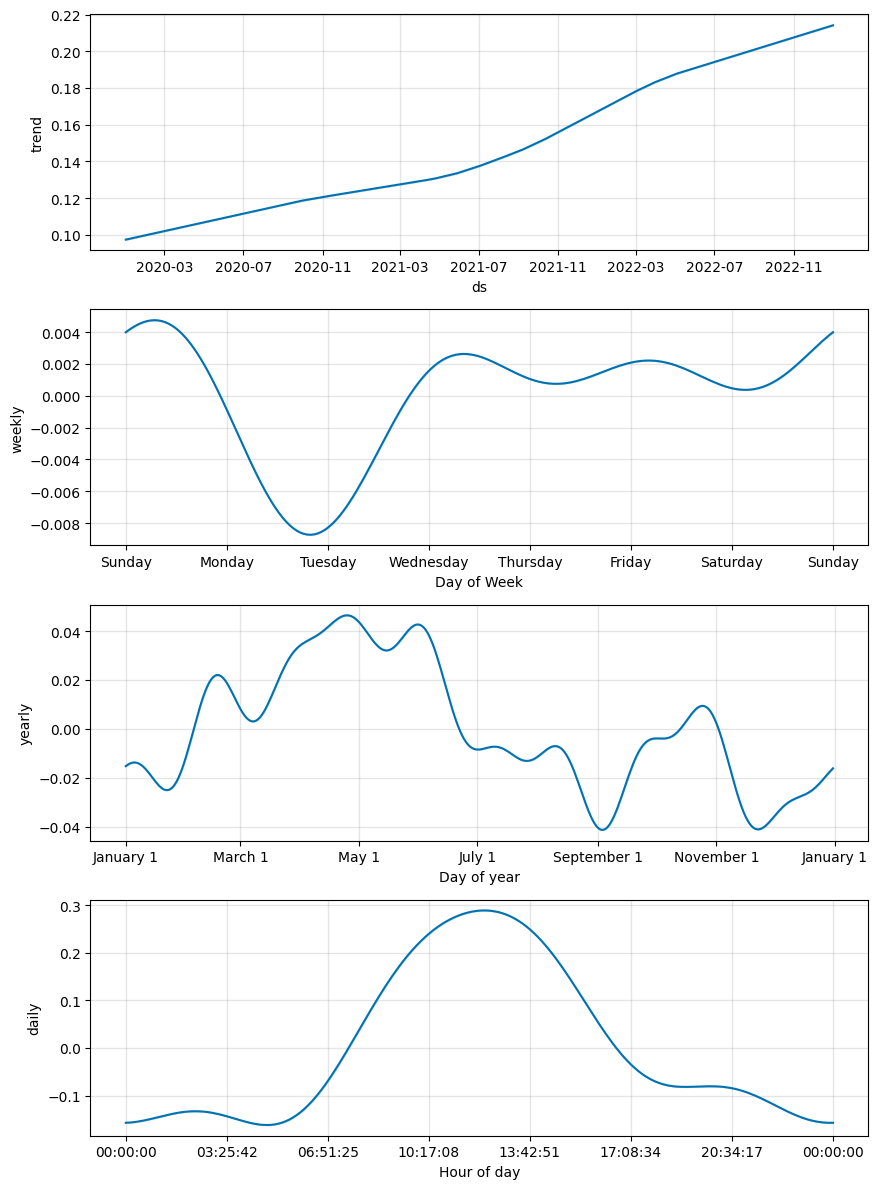

In [107]:
#예측 구성 요소 시각화
print(best_m.plot_components(forecast))

In [ ]:
#예측된 값을 원래 스케일로 역변환
predictions = target_scaler.inverse_transform(forecast_test.yhat.values.reshape(-1,1))
# 테스트 데이터셋의 실제 타겟 변수 값을 가져옴
actual_values = test['Solarpower'].values.reshape(-1, 1)
actual_values = target_scaler.inverse_transform(actual_values)

In [110]:
# MAPE 계산 함수 정의
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

<ipython-input-110-d65f9915a241>:3: RuntimeWarning:

divide by zero encountered in divide



평균 제곱 오차 (MSE): 1247.1826337827015
평균 절대 오차 (MAE): 26.89147654799841
결정 계수 (R2): 0.7697147088221437
평균 절대 백분율 오차 (MAPE): inf
평균 제곱근 오차 (RMSE): 35.31547300805557


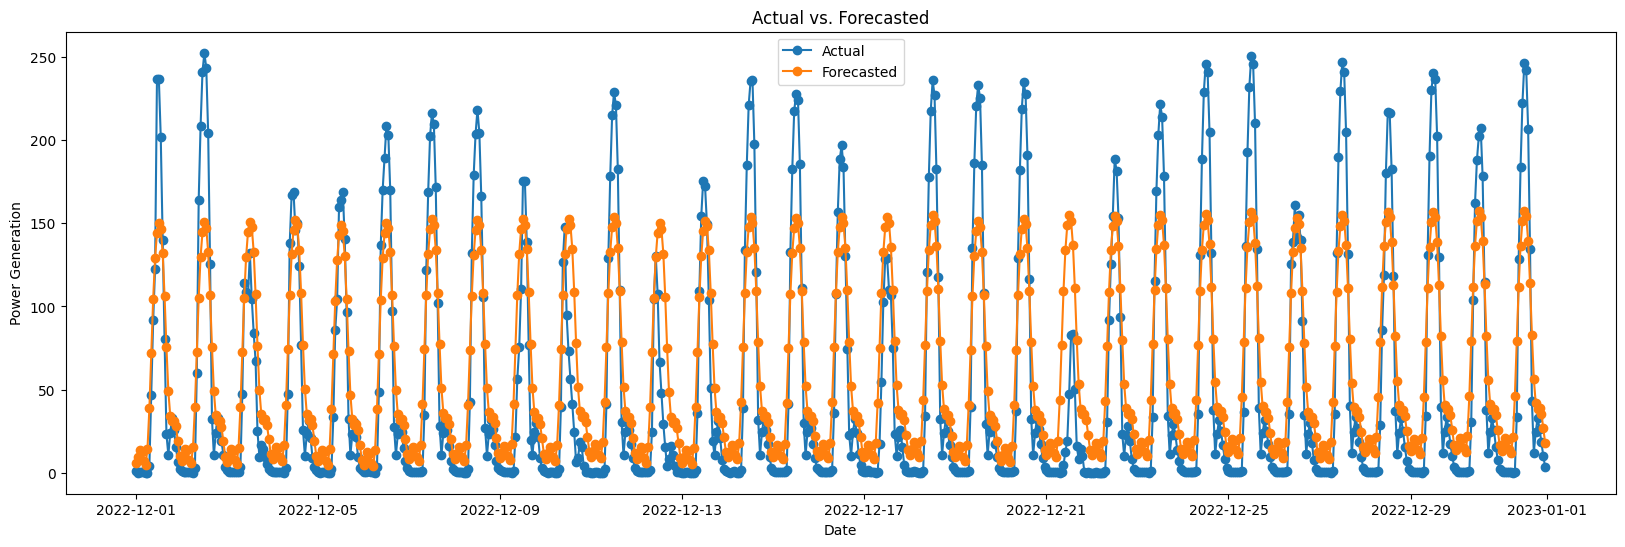

In [111]:
# 평가 지표 계산
mse = mean_squared_error(actual_values, predictions)
mae = mean_absolute_error(actual_values, predictions)
r2 = r2_score(actual_values, predictions)
mape = mean_absolute_percentage_error(actual_values, predictions)
rmse = np.sqrt(mse)

# 평가 지표 출력
print("평균 제곱 오차 (MSE):", mse)
print("평균 절대 오차 (MAE):", mae)
print("결정 계수 (R2):", r2)
print("평균 절대 백분율 오차 (MAPE):", mape)
print("평균 제곱근 오차 (RMSE):", rmse)

# 실제 값과 예측값 시각화
plt.figure(figsize=(20, 6))
plt.plot(test['Date'], actual_values, label='Actual', marker='o')
plt.plot(test['Date'], predictions, label='Forecasted', marker='o')
plt.xlabel('Date')
plt.ylabel('Power Generation')
plt.title('Actual vs. Forecasted')
plt.legend()
plt.show()


DEBUG:cmdstanpy:input tempfile: /tmp/tmpo1fbqr2_/5dieng_w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo1fbqr2_/zarin8_1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46307', 'data', 'file=/tmp/tmpo1fbqr2_/5dieng_w.json', 'init=/tmp/tmpo1fbqr2_/zarin8_1.json', 'output', 'file=/tmp/tmpo1fbqr2_/prophet_model1q2a9922/prophet_model-20230911151132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:11:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:11:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-110-d65f9915a241>:3: RuntimeWarning:

divide by zero encountered in divide



평균 제곱 오차 (MSE): 1247.1826337827015
평균 절대 오차 (MAE): 26.89147654799841
결정 계수 (R2): 0.7697147088221437
평균 절대 백분율 오차 (MAPE): inf
평균 제곱근 오차 (RMSE): 35.31547300805557


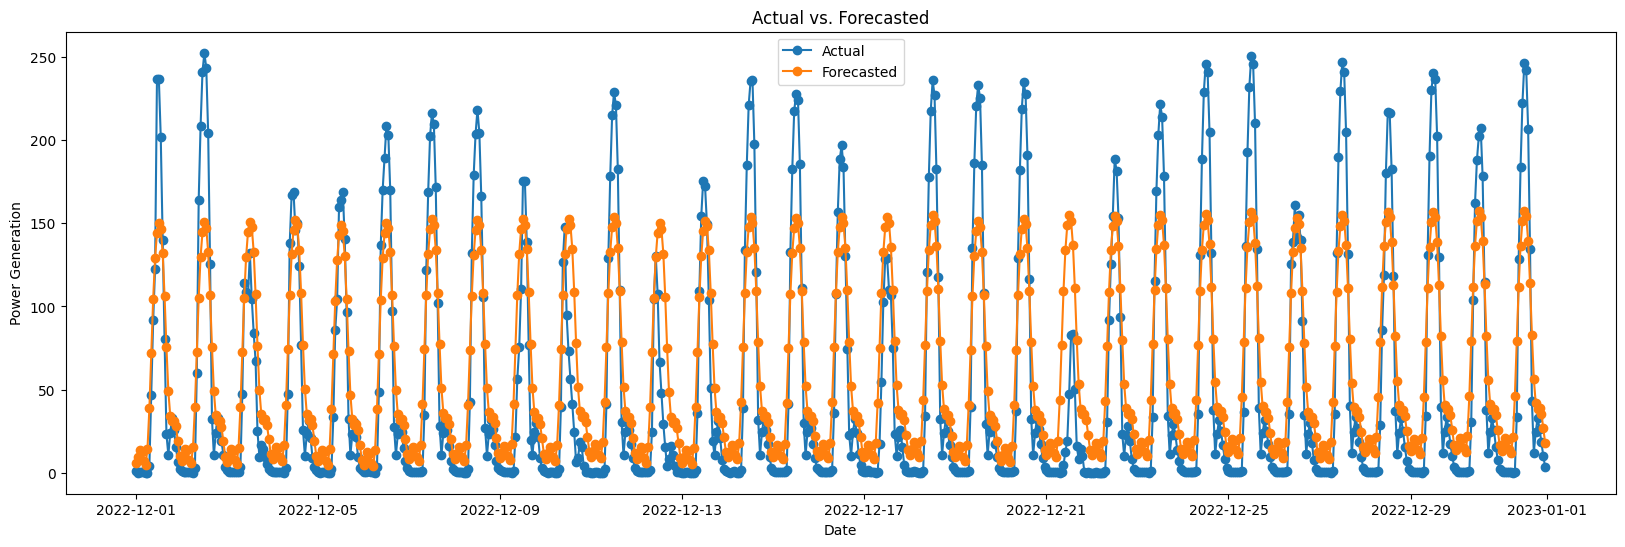

In [112]:
#튜닝 안한거
m_normal = Prophet()
m_normal.fit(prophet_train)
future_normal = m_normal.make_future_dataframe(periods=len(test), freq='H')
forecast_no = m_normal.predict(future_normal)
forecast_test_no = forecast_no[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(len(test))
#예측된 값을 원래 스케일로 역변환
predictions_no= target_scaler.inverse_transform(forecast_test_no.yhat.values.reshape(-1,1))
# 테스트 데이터셋의 실제 타겟 변수 값을 가져옴
actual_values = test['Solarpower'].values.reshape(-1, 1)
actual_values = target_scaler.inverse_transform(actual_values)
# 평가 지표 계산
mse = mean_squared_error(actual_values, predictions)
mae = mean_absolute_error(actual_values, predictions)
r2 = r2_score(actual_values, predictions)
mape = mean_absolute_percentage_error(actual_values, predictions)
rmse = np.sqrt(mse)

# 평가 지표 출력
print("평균 제곱 오차 (MSE):", mse)
print("평균 절대 오차 (MAE):", mae)
print("결정 계수 (R2):", r2)
print("평균 절대 백분율 오차 (MAPE):", mape)
print("평균 제곱근 오차 (RMSE):", rmse)

# 실제 값과 예측값 시각화
plt.figure(figsize=(20, 6))
plt.plot(test['Date'], actual_values, label='Actual', marker='o')
plt.plot(test['Date'], predictions, label='Forecasted', marker='o')
plt.xlabel('Date')
plt.ylabel('Power Generation')
plt.title('Actual vs. Forecasted')
plt.legend()
plt.show()


# AutoML 학습을 위한 데이터셋 설정

In [58]:
# H2O 라이브러리 초기화
h2o.init()

# H2O 데이터프레임으로 변환
h2o_train = h2o.H2OFrame(train.drop('Date', axis=1))

# Date 열을 제외한 특성과 타겟 변수를 정의
x = h2o_train.columns
x.remove('Solarpower')

y = 'Solarpower'

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20.1" 2023-08-24; OpenJDK Runtime Environment (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmptkk7311d
  JVM stdout: /tmp/tmptkk7311d/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmptkk7311d/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_unknownUser_j24i4z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [59]:
# AutoML 설정 및 모델 훈련 (모든 파라미터를 원하는 값으로 변경하여 설정)
aml = H2OAutoML(
     max_runtime_secs=3600,     # AutoML 실행에 허용할 최대 시간 (초)
    # max_models=20,             # 생성할 최대 모델 수
    stopping_metric='RMSE',    # 조기 종료를 위한 평가 지표
    stopping_tolerance=0.01,  # 조기 종료를 위한 허용 오차
    stopping_rounds=3,         # 조기 종료를 위한 반복 횟수
    nfolds=5,                  # 교차 검증(fold)의 개수
    seed=42,                   # 랜덤 시드
     # exclude_algos = ["StackedEnsemble"],

   #include_algos=['Deeplearning'], #'DRF', 'XGBoost'],  # 사용할 알고리즘들의 리스트
    keep_cross_validation_predictions=True,  # 교차 검증 예측 결과 보존 여부
    keep_cross_validation_models=False,      # 교차 검증 모델 보존 여부
    keep_cross_validation_fold_assignment=False,  # 교차 검증 폴드 할당 보존 여부
    sort_metric='RMSE',        # 성능 측정 기준
    export_checkpoints_dir=None  # 모델 체크포인트를 내보낼 디렉토리
)

aml.train(x=x, y=y, training_frame=h2o_train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),8/77
# GBM base models (used / total),6/32
# XGBoost base models (used / total),2/38
# DRF base models (used / total),0/2
# DeepLearning base models (used / total),0/4
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


# Automl 학습결과 확인

